In [1]:
import os
from dotenv import load_dotenv
import numpy as np
import tensorflow as tf
import pandas as pd
import datetime

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# try:
#   tf.config.experimental.set_memory_growth(physical_devices[0], True)
# except:
#   # Invalid device or cannot modify virtual devices once initialized.
#   pass

load_dotenv(override=True)

DATA_PATH = os.getenv('DATA_PATH')
print(DATA_PATH)

# Choose subontology (CCO, MFO or BPO)
SO = 'MFO'

2023-08-24 10:18:45.820106: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 10:18:46.312780: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1
/mnt/e/ML/cafa-5-protein-function-prediction


2023-08-24 10:18:47.101557: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 10:18:47.122385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 10:18:47.122712: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.


## Reading fasta, obo and tsv files

In [2]:
from Bio import SeqIO

sequences = [rec.seq for rec in SeqIO.parse(os.path.join(DATA_PATH, "Train/train_sequences.fasta"),"fasta")]
ids = [rec.id for rec in SeqIO.parse(os.path.join(DATA_PATH, "Train/train_sequences.fasta"),"fasta")]

In [3]:
import networkx
import obonet

# Read the taxrank ontology
url = os.path.join(DATA_PATH, "Train/go-basic.obo")
graph = obonet.read_obo(url)



In [4]:
df = pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

dfSO = df.loc[df["aspect"]==SO]
uniqueTerms = dfSO["term"].unique()
termsArr = list(dfSO["term"].to_numpy())

uniqueTermsDict={}
for i,el in enumerate(uniqueTerms):
    uniqueTermsDict[el] = i
    
print(dfSO.shape)
df=dfSO

df.set_index("EntryID", inplace=True)

(670114, 3)


In [5]:
testID = df.index.to_list()[0]

In [6]:
dfGo = pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

dfGo = dfGo.loc[dfGo["aspect"]==SO]

dfGo.set_index("term", inplace=True)

## GO analysis

In [7]:
item_counts = df["term"].value_counts()

In [8]:
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

In [9]:
relevantNodes=[]
for layer, nodes in enumerate(networkx.topological_generations(graph)):
    if layer<20:
        relevantNodes = relevantNodes + nodes

## Label encoding

The task is a multilabel classification: The output has several possible targets (Gene Ontologies) but each can only be 1 (existing) or 0 (non existing)

Extract label weights from IA

In [10]:
dfIa = pd.read_csv(os.path.join(DATA_PATH, "IA.txt"), sep='\t', header=None)

dfIa.set_index(0, inplace=True)

labelWeights=[]
allIndices = dfIa.index.tolist()



notFound=0
for go in item_counts.index.to_list():
    if go in allIndices:
        labelWeights.append(dfIa.loc[go].to_numpy()[0])
    else:
        notFound += 1
        labelWeights.append(0)

print("Not found GOs: {} (set to 0)".format(notFound))

Not found GOs: 0 (set to 0)


In [11]:
topGOs=item_counts.index.to_list()

threshold=0
labelWeights=np.array(labelWeights)
selection = labelWeights>threshold
topGOs=np.array(topGOs)[selection]

if os.path.exists(os.path.join(DATA_PATH, "GODataSizes_"+SO+".npy")):
    print("Loading presaved data")
    GODataSizes = np.load(os.path.join(DATA_PATH, "GODataSizes_"+SO+".npy"))
else:
    GODataSizes= [dfGo.loc[g].size for g in topGOs]
    np.save(os.path.join(DATA_PATH, "GODataSizes_"+SO), GODataSizes)


Loading presaved data


In [12]:
#At least 10 samples
print(np.count_nonzero(np.array(GODataSizes)>20))
GODataSizes= np.array(GODataSizes)
GOsWithSufficientData = topGOs[GODataSizes>20]


2099


In [13]:
#Reduce to relevant GOs (see Data Exploration.ipynb)

finalGOSet =[]
for g in GOsWithSufficientData:
    if g in relevantNodes:
        finalGOSet.append(g)

print(len(finalGOSet))

2099


In [14]:
from sklearn.preprocessing import MultiLabelBinarizer
import pickle


mlb = MultiLabelBinarizer()
mlb.fit([finalGOSet])

dftest=df.loc[testID]
indices = dftest["term"].to_numpy()
print(indices)
print(mlb.transform([indices]))
print(len(mlb.classes_))

with open(os.path.join(DATA_PATH,'MLB_'+SO+'.pkl'), 'wb') as f:
    pickle.dump(mlb, f)

['GO:0003674' 'GO:0003953' 'GO:0016787' 'GO:0016799' 'GO:0016798'
 'GO:0003824']
[[0 0 0 ... 0 0 0]]
2099


/home/manuel/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['GO:0003674'] will be ignored
  warnings.warn(


In [15]:
labelWeightsCorr=[]

notFound=0
for go in mlb.classes_:
    if go in allIndices:
        labelWeightsCorr.append(dfIa.loc[go].to_numpy()[0])
    else:
        notFound += 1
        labelWeightsCorr.append(0)

print("Not found GOs: {} (set to 0)".format(notFound))
labelWeightsCorr=np.array(labelWeightsCorr)

Not found GOs: 0 (set to 0)


## Amino acids encoding

In [16]:
aa_dict = {'A': 1, 'B':24, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 21, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'U': 22, 'V': 18, 'W': 19, 'Y': 20, 'X':30, 'Z':23}

## Build Dataset

In [17]:
seqLengths = [len(seq) for seq in sequences]
maxLen = max(seqLengths)
print("The max. length of the sequences is {}".format(maxLen))

The max. length of the sequences is 35375


In [18]:

dfAll=pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

soEntries = dfAll.loc[dfAll["aspect"]==SO]
soEntryIds = soEntries["EntryID"].unique()

# print(len(seqEntries))
print(soEntryIds)

# SoSequences = []
# for entry in soEntryIds:
#     SoSequences.append(sequences[ids.index(entry)])

# print(len(SoSequences))
dfAll.set_index("EntryID", inplace=True)

['A0A009IHW8' 'A0A023FBW4' 'A0A023FBW7' ... 'X5L1L5' 'X5L565' 'X5M5N0']


In [19]:
import warnings
from itertools import product
from tqdm import tqdm
import os

TRAIN_VAL_SPLIT = 0.7
nonRelevantThreshold=0.01
k = 3

allAA = list(aa_dict.keys())
allAA.sort()
allCombinations= list(product(*(allAA for i in range(k))))
allCombinations=np.array([''.join(el) for el in allCombinations])

positionDict = dict(zip(allCombinations, np.arange(0,allCombinations.size).T))

#Use numpy vectorize to speed up the mapping (hopefully)
mapping = lambda x: aa_dict[x]
vectMapping = np.vectorize(mapping)

# Shuffle the data
import random
random.seed(516213)
c = list(zip(sequences, ids))
random.shuffle(c)
sequencesShuffle, idsShuffle = zip(*c)


#Train Validation Split
split = int(np.floor(len(sequencesShuffle)*TRAIN_VAL_SPLIT))
print(split)
trainSeq = sequencesShuffle[0:split]
valSeq = sequencesShuffle[split+1:]
trainIds = idsShuffle[0:split]
valIds = idsShuffle[split+1:]


def generator():
  for i,seq in enumerate(trainSeq):
      entryId = trainIds[i]
      if entryId in soEntryIds:
        labelData = df.loc[entryId]
        # indices = labelData["termToken"].to_numpy()
        indices = labelData["term"].to_numpy()
      else: 
        indices=[]

      with warnings.catch_warnings():
          #supress the warnings for unknown classes
          warnings.simplefilter("ignore")
          y = mlb.transform([indices])

      # if np.count_nonzero(y)==0 and np.random.random()>nonRelevantThreshold:
      #   continue

      
      kmers = [seq[j:j+k] if j < len(seq)-(k-1) else 0 for j,el in enumerate(seq)]
      kmers = kmers[0:-(k-1)]
      kmers = [str(el) for el in kmers]
      values, counts = np.unique(kmers, return_counts=True)
      freqVector=np.zeros(allCombinations.shape)
      for l,v in enumerate(values):
          freqVector[positionDict[v]] = counts[l]
      yield (freqVector,y[0])


def generatorVal():
  for i,seq in enumerate(valSeq):
      entryId = valIds[i]
      if entryId in soEntryIds:
        labelData = df.loc[entryId]
        # indices = labelData["termToken"].to_numpy()
        indices = labelData["term"].to_numpy()
      else:
        indices=[]

      with warnings.catch_warnings():
          #supress the warnings for unknown classes
          warnings.simplefilter("ignore")
          y = mlb.transform([indices])

      # if np.count_nonzero(y)==0 and np.random.random()>nonRelevantThreshold:
      #   continue
      
      kmers = [seq[j:j+k] if j < len(seq)-(k-1) else 0 for j,el in enumerate(seq)]
      kmers = kmers[0:-(k-1)]
      kmers = [str(el) for el in kmers]
      values, counts = np.unique(kmers, return_counts=True)
      freqVector=np.zeros(allCombinations.shape)
      for l,v in enumerate(values):
          freqVector[positionDict[v]] = counts[l]
      yield (freqVector,y[0])
        

99572


In [20]:
g = generator()
test = next(g)
print("The first sample: \n{}\n{}".format(test[0].shape, test[0][0:100]))
print("The first sample has {} classes".format(np.count_nonzero(test[1])))

The first sample: 
(15625,)
[0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0.]
The first sample has 5 classes


## Tensorflow Classification

In [21]:

xSize = allCombinations.shape[0]

dataset = tf.data.Dataset.from_generator(generator, output_signature=(
         tf.TensorSpec(shape=(xSize,), dtype=tf.int32),
         tf.TensorSpec(shape=(len(mlb.classes_),), dtype=tf.int32)))
print(list(dataset.take(1)))

datasetVal = tf.data.Dataset.from_generator(generatorVal, output_signature=(
         tf.TensorSpec(shape=(None,), dtype=tf.int32),
         tf.TensorSpec(shape=(len(mlb.classes_),), dtype=tf.int32)))

2023-08-24 10:19:05.492976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 10:19:05.493440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 10:19:05.493846: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 10:19:06.294355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 10:19:06.294733: I tensorflow/compile

[(<tf.Tensor: shape=(15625,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>, <tf.Tensor: shape=(2099,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)]


In [22]:
%load_ext tensorboard


In [23]:
from tensorflow.keras import layers

VOCAB_SIZE=len(aa_dict)
EMBED_DIM=10

def createModel():
    inputs = tf.keras.Input(shape=(xSize,))
    # x=layers.Embedding(VOCAB_SIZE, EMBED_DIM, name="embedding")(inputs)
    x = layers.BatchNormalization()(tf.expand_dims(inputs,2))

    x=layers.Conv1D(16, 7)(x)
    x=layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x=layers.Conv1D(16, 7)(x)
    x=layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    
    x=layers.Conv1D(16, 7)(x)
    x=layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x=layers.Conv1D(32, 7)(x)
    x=layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x=layers.Conv1D(32, 7,strides=2)(x)
    x=layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x=layers.Conv1D(32, 7,strides=2)(x)
    x=layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    
    x=layers.Conv1D(32, 7, strides=2)(x)
    x=layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    
    x=layers.Conv1D(32, 7, strides=2)(x)
    x=layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    
    

    # x=layers.Conv1D(32, 5, activation=tf.keras.activations.relu)(x)
    # x=layers.Conv1D(32, 5, activation=tf.keras.activations.relu)(x)
    # x=layers.Conv1D(32, 5, activation=tf.keras.activations.relu)(x)
    x=layers.Flatten()(x)
    x=layers.Dense(64)(x)
    x=layers.LeakyReLU()(x)
    x=layers.Dense(64)(x)
    x=layers.LeakyReLU()(x)
    x=layers.Dense(64)(x)
    x=layers.LeakyReLU()(x)
    outputs=layers.Dense(len(mlb.classes_), activation=tf.keras.activations.sigmoid)(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name="embedConvModel")

# model = createModel()

# model.summary()


Model: "DenseModelKmer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15625)]           0         
                                                                 
 dense (Dense)               (None, 128)               2000128   
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                    

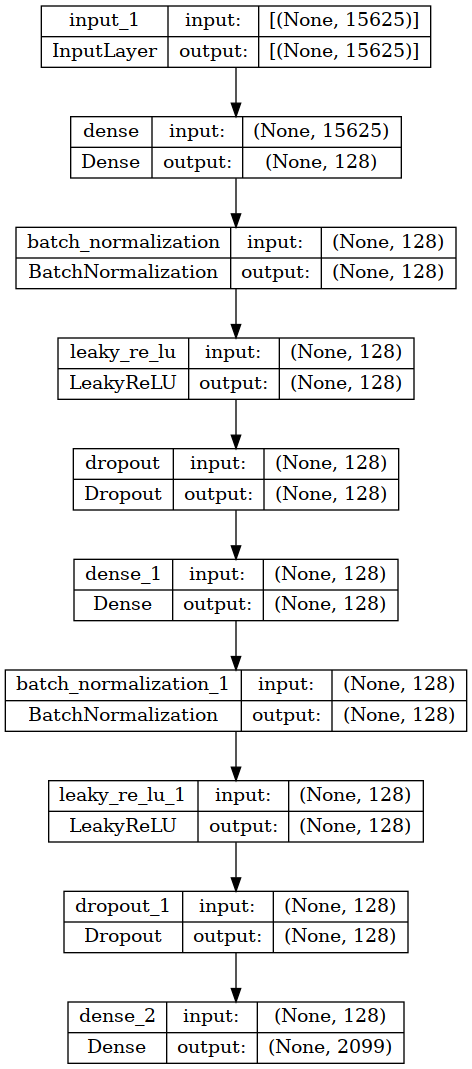

In [24]:
from tensorflow.keras import layers

VOCAB_SIZE=len(aa_dict)
EMBED_DIM=10

def createModel():
    inputs = tf.keras.Input(shape=(xSize,))
    # x=layers.Embedding(VOCAB_SIZE, EMBED_DIM, name="embedding")(inputs)
    # x = layers.BatchNormalization()(tf.expand_dims(inputs,2))

    x = layers.Dense(128)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.1)(x)

    outputs=layers.Dense(len(mlb.classes_), activation=tf.keras.activations.sigmoid)(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name="DenseModelKmer")

model = createModel()

model.summary()

dot_img_file = './'+model.name +'.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


In [25]:
import matplotlib.pyplot as plt
#Learning rate schedule
initial_learning_rate = 0.001
decaySteps=5000
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate, first_decay_steps=decaySteps,
                                                                t_mul=2.0, m_mul=0.7)
# lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate, decay_steps=decaySteps, alpha=0.01)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,decay_steps=decaySteps,decay_rate=0.9,staircase=False)
step = np.linspace(0,decaySteps*3)
lr = lr_schedule(step)
# plt.figure(figsize = (8,6))
# # plt.yscale("log")
# plt.plot(step, lr)
# plt.ylim([0,max(plt.ylim())])
# plt.xlabel('step')
# _ = plt.ylabel('Learning Rate')

In [26]:
from utils import *

In [27]:

BATCH_SIZE=64
LOG_INTERVAL=20
epochs = 15
saveModel=False


log_dir = "./logs/"+model.name+"/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+"_"+SO
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,
                                                      write_graph=True, update_freq=5)


summary_writer = tf.summary.create_file_writer(log_dir)

# Instantiate an optimizer .
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
optimizer = tf.keras.optimizers.Adam(learning_rate=6e-4)

# Instantiate a loss function.
# loss_fn = tf.keras.losses.BinaryCrossentropy()
# loss_fn = WeightedBinaryCE(np.ones(len(mlb.classes_)))
# loss_fn = WeightedBinaryCE(labelWeightsCorr)
# loss_fn = WeightedComboLoss(labelWeightsCorr, alpha=0.5, beta=0.5, labelSmoothing=0.05)
loss_fn = WeightedComboLoss(labelWeightsCorr, alpha=0.5, beta=0.5)

train_acc_metric = WeightedAccuracy(classWeights=labelWeightsCorr)
train_f1_metric = WeightedF1(classWeights=labelWeightsCorr, threshold=0.5)
train_prec = WeightedPrecision(classWeights=labelWeightsCorr)
train_rec = WeightedRecall(classWeights=labelWeightsCorr)

val_acc_metric = WeightedAccuracy(classWeights=labelWeightsCorr)
val_f1_metric = WeightedF1(classWeights=labelWeightsCorr, threshold=0.5)
val_prec = WeightedPrecision(classWeights=labelWeightsCorr)
val_rec = WeightedRecall(classWeights=labelWeightsCorr)

batchedDataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
batchedDatasetVal = datasetVal.batch(BATCH_SIZE, drop_remainder=False)

# batchedDataset = batchedDataset.cache(os.path.join(DATA_PATH, "datasetCache"+SO))
# batchedDatasetVal = batchedDatasetVal.cache(os.path.join(DATA_PATH, "datasetCacheVal"+SO))

@tf.function()
def trainStep(x_batch_train, y_batch_train):
    with tf.GradientTape() as tape:

        probs = model(x_batch_train, training=True) 
        loss_value = loss_fn(y_batch_train, probs)

    grads = tape.gradient(loss_value, model.trainable_weights)
    #Gradient clipping
    # grads = [tf.clip_by_norm(g, 2.0) for g in grads]

    train_acc_metric.update_state(y_batch_train, probs)
    train_f1_metric.update_state(y_batch_train, probs)
    train_prec.update_state(y_batch_train, probs)
    train_rec.update_state(y_batch_train, probs)

    optimizer.apply_gradients(zip(grads, model.trainable_weights)) 
    return loss_value

@tf.function()
def valStep(x_batch_val, y_batch_val):
    valProbs = model(x_batch_val, training=False)
    # Update val metrics
    val_acc_metric.update_state(y_batch_val, valProbs)
    val_f1_metric.update_state(y_batch_val, valProbs)
    val_prec.update_state(y_batch_val, valProbs)
    val_rec.update_state(y_batch_val, valProbs)

maxStep=0

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch+1,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(batchedDataset):

        loss_value =trainStep(x_batch_train,y_batch_train)

        # Log 
        if step % LOG_INTERVAL == 0:
            template = 'Epoch {}/Step {}, Loss: {:.5f}, Accuracy: {:.5f}, F1: {:.4f}, Prec: {:.4f}, Rec: {:.4f}, lr: {:.5f}'
            print(template.format(epoch+1, step,loss_value.numpy(), 
                                    train_acc_metric.result(),train_f1_metric.result(),
                                    train_prec.result(), train_rec.result(), optimizer.learning_rate.numpy()))
            
            with summary_writer.as_default():
                tf.summary.scalar('loss', loss_value, step=maxStep*epoch+step)
                tf.summary.scalar('accuracy', train_acc_metric.result(), step=maxStep*epoch+step)
                tf.summary.scalar('f1', train_f1_metric.result(), step=maxStep*epoch+step)
                tf.summary.scalar('prec', train_prec.result(), step=maxStep*epoch+step)
                tf.summary.scalar('rec', train_rec.result(), step=maxStep*epoch+step)
                tf.summary.scalar('learning rate', optimizer.learning_rate.numpy(), step=maxStep*epoch+step)
                summary_writer.flush()

    
    train_acc_metric.reset_states()
    train_f1_metric.reset_states()
    train_prec.reset_states()
    train_rec.reset_states()

    maxStep=step

    print("Epoch finished. Start validation")
    for x_batch_val, y_batch_val in batchedDatasetVal:
        valStep(x_batch_val, y_batch_val)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    val_f1 = val_f1_metric.result()
    val_f1_metric.reset_states()
    val_precision = val_prec.result()
    val_prec.reset_states()
    val_recall = val_rec.result()
    val_rec.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Validation f1: %.4f" % (float(val_f1),))
    print("Validation precision: %.4f" % (float(val_precision),))
    print("Validation recall: %.4f" % (float(val_recall),))
    with summary_writer.as_default():
        tf.summary.scalar('valAcc', float(val_acc), step=epoch)
        tf.summary.scalar('valF1', float(val_f1), step=epoch)
        tf.summary.scalar('valPrecision', float(val_precision), step=epoch)
        tf.summary.scalar('valRecall', float(val_recall), step=epoch)
        summary_writer.flush()
    if saveModel:
      model.save(os.path.join(DATA_PATH, "model_"+SO+"_epoch_{}_valF1Score{:.3f}".format(epoch, float(val_f1))))


Start of epoch 1


2023-07-28 23:58:41.365292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-28 23:58:43.302180: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fa993db0580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-28 23:58:43.302236: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-07-28 23:58:43.305099: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-28 23:58:43.414928: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-28 23:58:43.502

Epoch 1/Step 0, Loss: 0.00388, Accuracy: 0.50109, F1: 0.0017, Prec: 0.2887, Rec: 0.0009, lr: 0.00060
Epoch 1/Step 20, Loss: 0.00404, Accuracy: 0.50577, F1: 0.0022, Prec: 0.3082, Rec: 0.0011, lr: 0.00060
Epoch 1/Step 40, Loss: 0.00323, Accuracy: 0.51492, F1: 0.0024, Prec: 0.3271, Rec: 0.0012, lr: 0.00060
Epoch 1/Step 60, Loss: 0.00330, Accuracy: 0.52782, F1: 0.0026, Prec: 0.3446, Rec: 0.0013, lr: 0.00060
Epoch 1/Step 80, Loss: 0.00270, Accuracy: 0.55014, F1: 0.0029, Prec: 0.3582, Rec: 0.0015, lr: 0.00060
Epoch 1/Step 100, Loss: 0.00211, Accuracy: 0.58160, F1: 0.0034, Prec: 0.3644, Rec: 0.0017, lr: 0.00060
Epoch 1/Step 120, Loss: 0.00081, Accuracy: 0.62315, F1: 0.0046, Prec: 0.3693, Rec: 0.0023, lr: 0.00060
Epoch 1/Step 140, Loss: -0.00038, Accuracy: 0.66462, F1: 0.0069, Prec: 0.3707, Rec: 0.0035, lr: 0.00060
Epoch 1/Step 160, Loss: -0.00156, Accuracy: 0.69986, F1: 0.0096, Prec: 0.3715, Rec: 0.0049, lr: 0.00060
Epoch 1/Step 180, Loss: -0.00646, Accuracy: 0.72907, F1: 0.0130, Prec: 0.3741

2023-07-29 00:01:55.676678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Validation acc: 0.9989
Validation f1: 0.2607
Validation precision: 0.1996
Validation recall: 0.3853

Start of epoch 2
Epoch 2/Step 0, Loss: -0.17515, Accuracy: 0.99889, F1: 0.2885, Prec: 0.2429, Rec: 0.3553, lr: 0.00060
Epoch 2/Step 20, Loss: -0.16600, Accuracy: 0.99888, F1: 0.2640, Prec: 0.2087, Rec: 0.3686, lr: 0.00060
Epoch 2/Step 40, Loss: -0.16332, Accuracy: 0.99885, F1: 0.2570, Prec: 0.2003, Rec: 0.3662, lr: 0.00060
Epoch 2/Step 60, Loss: -0.16713, Accuracy: 0.99886, F1: 0.2631, Prec: 0.2053, Rec: 0.3738, lr: 0.00060
Epoch 2/Step 80, Loss: -0.16860, Accuracy: 0.99886, F1: 0.2609, Prec: 0.2024, Rec: 0.3752, lr: 0.00060
Epoch 2/Step 100, Loss: -0.15744, Accuracy: 0.99887, F1: 0.2591, Prec: 0.2006, Rec: 0.3730, lr: 0.00060
Epoch 2/Step 120, Loss: -0.13181, Accuracy: 0.99886, F1: 0.2590, Prec: 0.1998, Rec: 0.3755, lr: 0.00060
Epoch 2/Step 140, Loss: -0.16940, Accuracy: 0.99886, F1: 0.2590, Prec: 0.1999, Rec: 0.3758, lr: 0.00060
Epoch 2/Step 160, Loss: -0.16950, Accuracy: 0.99885, F1:

KeyboardInterrupt: 

In [ ]:

# model.save(os.path.join(DATA_PATH, "model_"+SO+"_epoch_{}_valf1Score{:.3f}".format(epoch, float(val_f1))))

In [ ]:

probs= model.predict(tf.expand_dims(list(datasetVal.take(32))[10][0], 0))
prediction= [1 if p > 0.5 else 0 for p in probs[0]]
probabilities= probs[probs>0.5]
# classes = np.argwhere(prediction)
print(mlb.inverse_transform(np.array([prediction])))
print(probabilities)

2023-07-27 15:01:50.530641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 295ms/step
[('GO:0005622', 'GO:0005634', 'GO:0005737', 'GO:0005829', 'GO:0005886', 'GO:0031410', 'GO:0031981', 'GO:0043226', 'GO:0043227', 'GO:0043229', 'GO:0043231', 'GO:0071944', 'GO:0110165', 'GO:0120025')]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
